In [1]:
import os
import uuid
import numpy as np 
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# This is used in order to show the plotted figures within this notebook
%matplotlib inline 
# This is used in order to show the tensorboard within this notebook             
#%load_ext tensorboard  
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
from math import ceil
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_roc_curve
from sklearn.model_selection import learning_curve
from sklearn.multioutput import MultiOutputClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from evaluate import run
import datetime


In [2]:
data = pd.read_csv('output/loan_dev.csv')
data

,Id,loan_date,loan_duration,loan_payments,Predicted,account_frequency,account_district_region,account_district_no_inhabitants,account_district_no_municipalities_0_499,account_district_no_municipalities_500_1999,...,last_trans_balance,mean_trans_balance,mean_trans_amount_absolute,mean_trans_amount_credit,mean_trans_amount_withdrawal,mean_trans_amount_signed,owner_male,owner_age,account_age_months,has_disponent
0,5314,930705,12,8033,1.0,1,7,94812,15,13,...,20100.0,12250.000000,5025.000000,5025.000000,NaN,5025.000000,0,45,3,0
1,5316,930711,36,4610,0.0,2,3,112709,48,20,...,52208.9,52083.859459,11015.635135,13523.158824,8884.240000,1411.051351,1,24,4,0
2,6863,930728,60,2118,0.0,2,3,77917,85,19,...,20272.8,30060.954167,5417.458333,5009.733333,6097.000000,844.708333,1,57,5,0
3,5325,930803,36,2939,0.0,2,2,107870,84,29,...,34307.3,41297.480000,8253.080000,9254.600000,7168.100000,1371.704000,0,53,6,0
4,7240,930906,60,4579,0.0,1,4,1204953,0,0,...,41112.9,57188.211111,18945.966667,21255.930769,16801.000000,1522.707407,1,14,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,961212,48,3242,0.0,2,1,226122,32,50,...,60694.1,44197.509884,4895.974419,6448.582857,3830.458824,352.872093,0,25,22,1
324,5625,961215,60,3703,1.0,2,7,45714,52,10,...,59578.8,55230.444068,11725.494915,13417.557143,10197.180645,1009.813559,1,57,12,0
325,6805,961221,48,938,0.0,2,1,285387,0,2,...,38384.3,41994.907692,7779.815385,8544.930000,6974.431579,984.215385,0,39,7,0
326,7233,961225,36,3217,0.0,2,6,93931,74,21,...,41878.1,56646.516129,13280.084677,16554.986275,10992.139726,337.726613,1,43,19,0


# Manual Outlier Detection

- 

--------------------------------------------------
Statistics of Id
--------------------------------------------------
Min: 4959
Max: 7308
Mean: 6205.658536585366
Median: 6227.5
Standard deviation: 667.985674726219
Skewness: -0.126359735421936
Variance: 446204.86163944204
Kurtosis: -1.168537695082133
Interquartile Range: 1133.0 | Q1: 5604.25 | Q3: 6737.25
--------------------------------------------------
Statistics of loan_date
--------------------------------------------------


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (1).

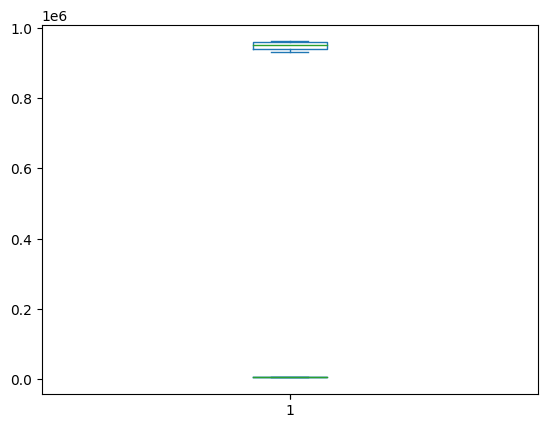

In [6]:
for col in data.columns:
    print("-"*50)
    print(f"Statistics of {col}")
    print("-"*50)
    #data[col].plot.box();

    q3, q1 = np.percentile(data[col], [75 ,25])

    print("Min: ", end="");                 print(data[col].min())
    print("Max: ", end="");                 print(data[col].max())
    print("Mean: ", end="");                print(data[col].mean())
    print("Median: ", end="");              print(data[col].median())
    print("Standard deviation: ", end="");  print(data[col].std())
    print("Skewness: ", end="");            print(data[col].skew())  
    print("Variance: ", end="");            print(data[col].var())
    print("Kurtosis: ", end="");            print(data[col].kurtosis())
    print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

# var() method returns the unbiased variance
# Medium-High std which indicates that the data is spread out and not clustered around the mean
# Skewness > 1 => it is skewed to the right

# Automatic Outlier Detection

# Dataset without Outliers